# Find Pairs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import seaborn as sns
from pathlib import Path
from varname import nameof
import re

plt.style.use("seaborn-v0_8-white")

In [6]:
df = pd.concat([pd.read_pickle(f"data/ts/pkls/europa_ROIs2017_146_{time_interval}.pkl") for time_interval in range(30)]).reset_index(drop=True)
df['continent'] = "europa"
display(df.shape)
df.head(3)

(9000, 211)

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
0                0.454809                   1.0       61.043858   
1                0.529204                   1.0       59.268642   
2                0.662275                   1.0       75.088112   

   0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
0        253.599681  134.218811     132.0   91.0  180.0  61.043858   
1        234.429785  111.995728     114.0   71.0  147.0  59.268642   
2        151.575154  113.379059     119.0   45.0  176.0  75.088112   

   1_traditional_contrast  ...  ndsi_under25  ndsi_p75  ndsi_over75       roi  \
0                0.474263  ...       16383.0  2.031579      16382.0  ROIs2017   
1                0.495702  ...       16381.0  2.000000      16382.0  ROIs2017   
2                0.716577  ...       16383.0  2.035088      16382.0  ROIs2017   

   season  patch  scene  time_interval       time  continent  
0  winter    191    146              0 2018-01-06     europa  
1  winter    146    146              0 2018-01-06     europa  
2  winter    261    146              0 2018-01-06     europa  

[3 rows x 211 columns]

In [7]:
df['cloud_percentage']

0       0.999950
1       0.997726
2       0.813221
3       0.999898
4       0.999954
          ...   
8995    0.999949
8996    0.999961
8997    0.999958
8998    0.999922
8999    0.999887
Name: cloud_percentage, Length: 9000, dtype: float32

In [8]:
def add_continent(pkl):
    df = pd.read_pickle(pkl)
    continent = pkl.name.split('_')[0]
    df['continent'] = continent
    return df

all_df = pd.concat([add_continent(pkl) for pkl in Path("data/ts/pkls").iterdir()]).reset_index(drop=True)

In [9]:
all_df.shape[0]

259890

In [10]:
ROI = "ROIs2017"
SCENE = 146
PATCH = 0
CONTINENT = "europa"
KEY_FEATS = [nameof(ROI), nameof(SCENE), nameof(PATCH), nameof(CONTINENT)]

In [11]:
def get_patch_df(df, patch: int):
    patch_df = df[df['patch'] == patch]
    return patch_df.sort_values('time_interval').reset_index(drop=True)

patch_df = get_patch_df(df, 0)

## Show samples

In [12]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0.1, 255)).astype(np.uint8)


def sigmoid(x):
    return 255 / (1 + np.exp(-2 * (scaled(x) / 255 - 0.5)))


def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

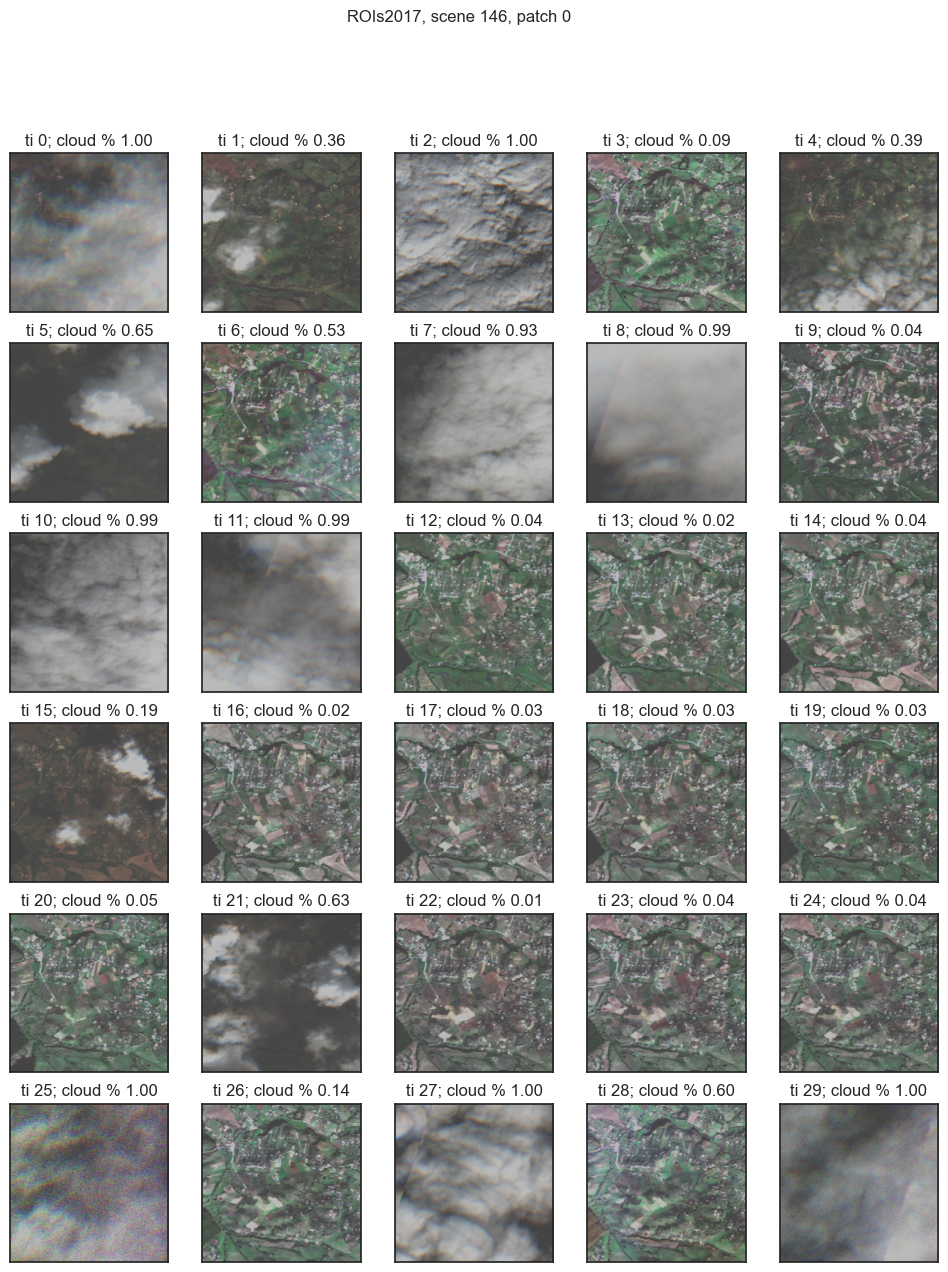

In [13]:
fig, axs = plt.subplots(6, 5, figsize=(12, 12 / 5 * 6))
axs = axs.reshape(-1)
for sample_img in Path('data/ts/sample_imgs/').iterdir():
    result = re.match(r"s2_(?P<roi>ROIs\d\d\d\d)_(?P<scene>\d+)_ImgNo_(?P<time_interval>\d+)_\d+-\d+-\d+_patch_(?P<patch>\d+)", sample_img.name)
    roi, scene, time_interval, patch = result.groups()
    axs[int(time_interval)].imshow(get_tci(rio.open(sample_img)))
    axs[int(time_interval)].get_xaxis().set_visible(False)
    axs[int(time_interval)].get_yaxis().set_visible(False)
    cp = patch_df[patch_df.time_interval == int(time_interval)].iloc[0]['cloud_percentage']
    axs[int(time_interval)].set_title("ti {}; cloud % {:.2f}".format(time_interval, cp))
fig.suptitle("ROIs2017, scene 146, patch 0")
fig.savefig(r'C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\eda\merge\cloud-percentages-patch-images.png')

## Band and Index Exploration 

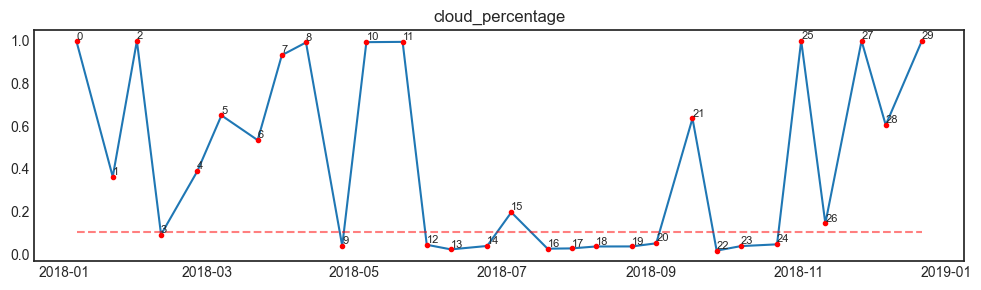

In [14]:
def show_feat_interval(df, feat, limit=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(df['time'], df[feat])
    ax.plot(df['time'], df[feat], 'ro', markersize=3)
    for i, row in df.iterrows():
        ax.text(row['time'], row[feat] + 0.01, row['time_interval'], fontsize=8)
    if limit:
        ax.plot(df['time'].iloc[[0, -1]], [limit, limit], '--r', alpha=0.5)
    ax.set_title(feat)

fig, ax = plt.subplots(1,1, figsize=(12, 3))
show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=ax)
fig.savefig(r'C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\eda\merge\cloud-percentages-patch-plot.png')

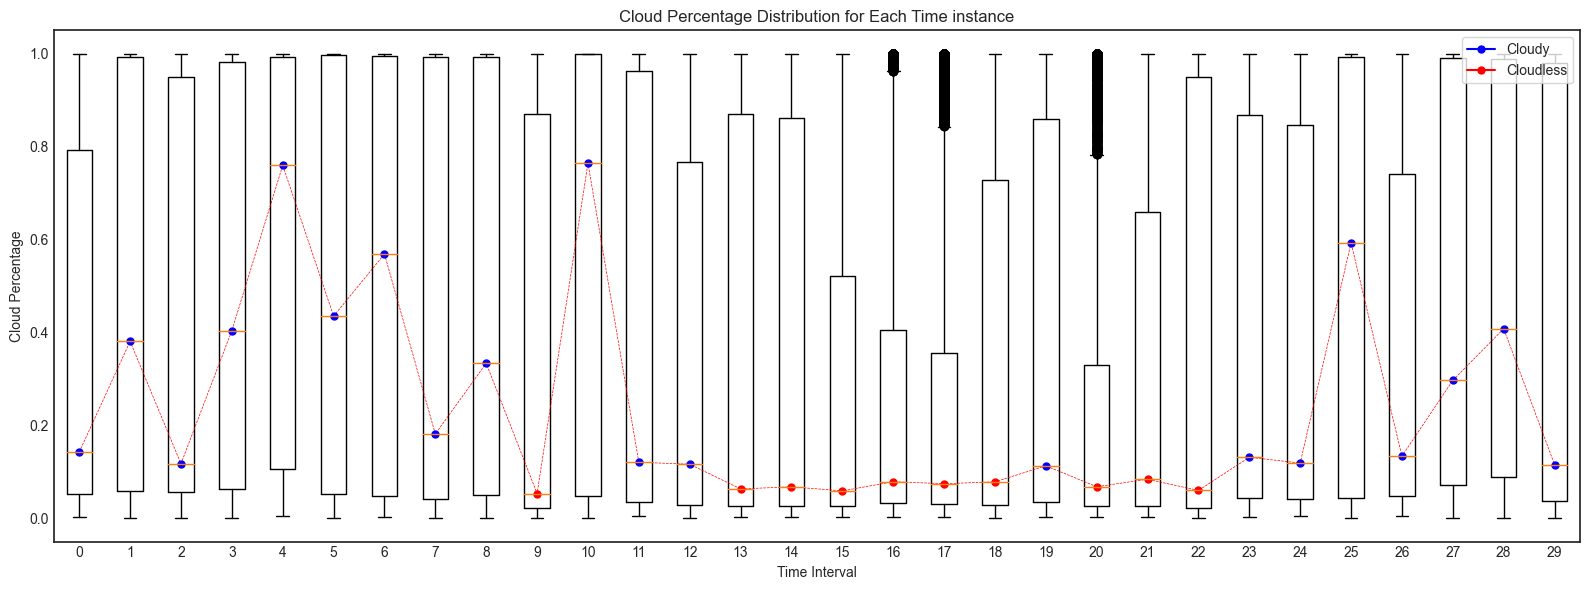

In [16]:
time_interval_groups = all_df.groupby('time_interval')
cloud_percentage_data = []

for time_int_group, group_df in time_interval_groups:
    cloud_percentage_data.append(group_df['cloud_percentage'])

# Create boxplots from the collected data
fig = plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
plt.boxplot(cloud_percentage_data, labels=time_interval_groups.groups.keys())
plt.xlabel('Time Interval')
plt.ylabel('Cloud Percentage')
plt.title('Cloud Percentage Distribution for Each Time instance')

# Plot medians as a line
medians = [np.median(data) for data in cloud_percentage_data]
plt.plot(np.arange(1, len(time_interval_groups.groups.keys()) + 1), medians, marker='o',  color='red', linestyle='dashed', markersize=3, linewidth=0.5)
foundBlue = False
foundRed = False
for idx, median in enumerate(medians):
    color = 'blue' if median > 0.1 else 'red'
    if color == 'blue' and not foundBlue:
        foundBlue = True
        plt.plot(idx + 1, median, marker='o', color=color, markersize=5, linewidth=1.5, label="Cloudy")
    elif color == "red" and not foundRed:
        foundRed = True
        plt.plot(idx + 1, median, marker='o', color=color, markersize=5, linewidth=1.5, label="Cloudless")
    else:
        plt.plot(idx + 1, median, marker='o', color=color, markersize=5, linewidth=1.5)
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()  # Ensure the plot elements are properly arranged
plt.show()
fig.savefig("imgs/doc/cloud-percentage-each-time-interval.png")

### Show bands

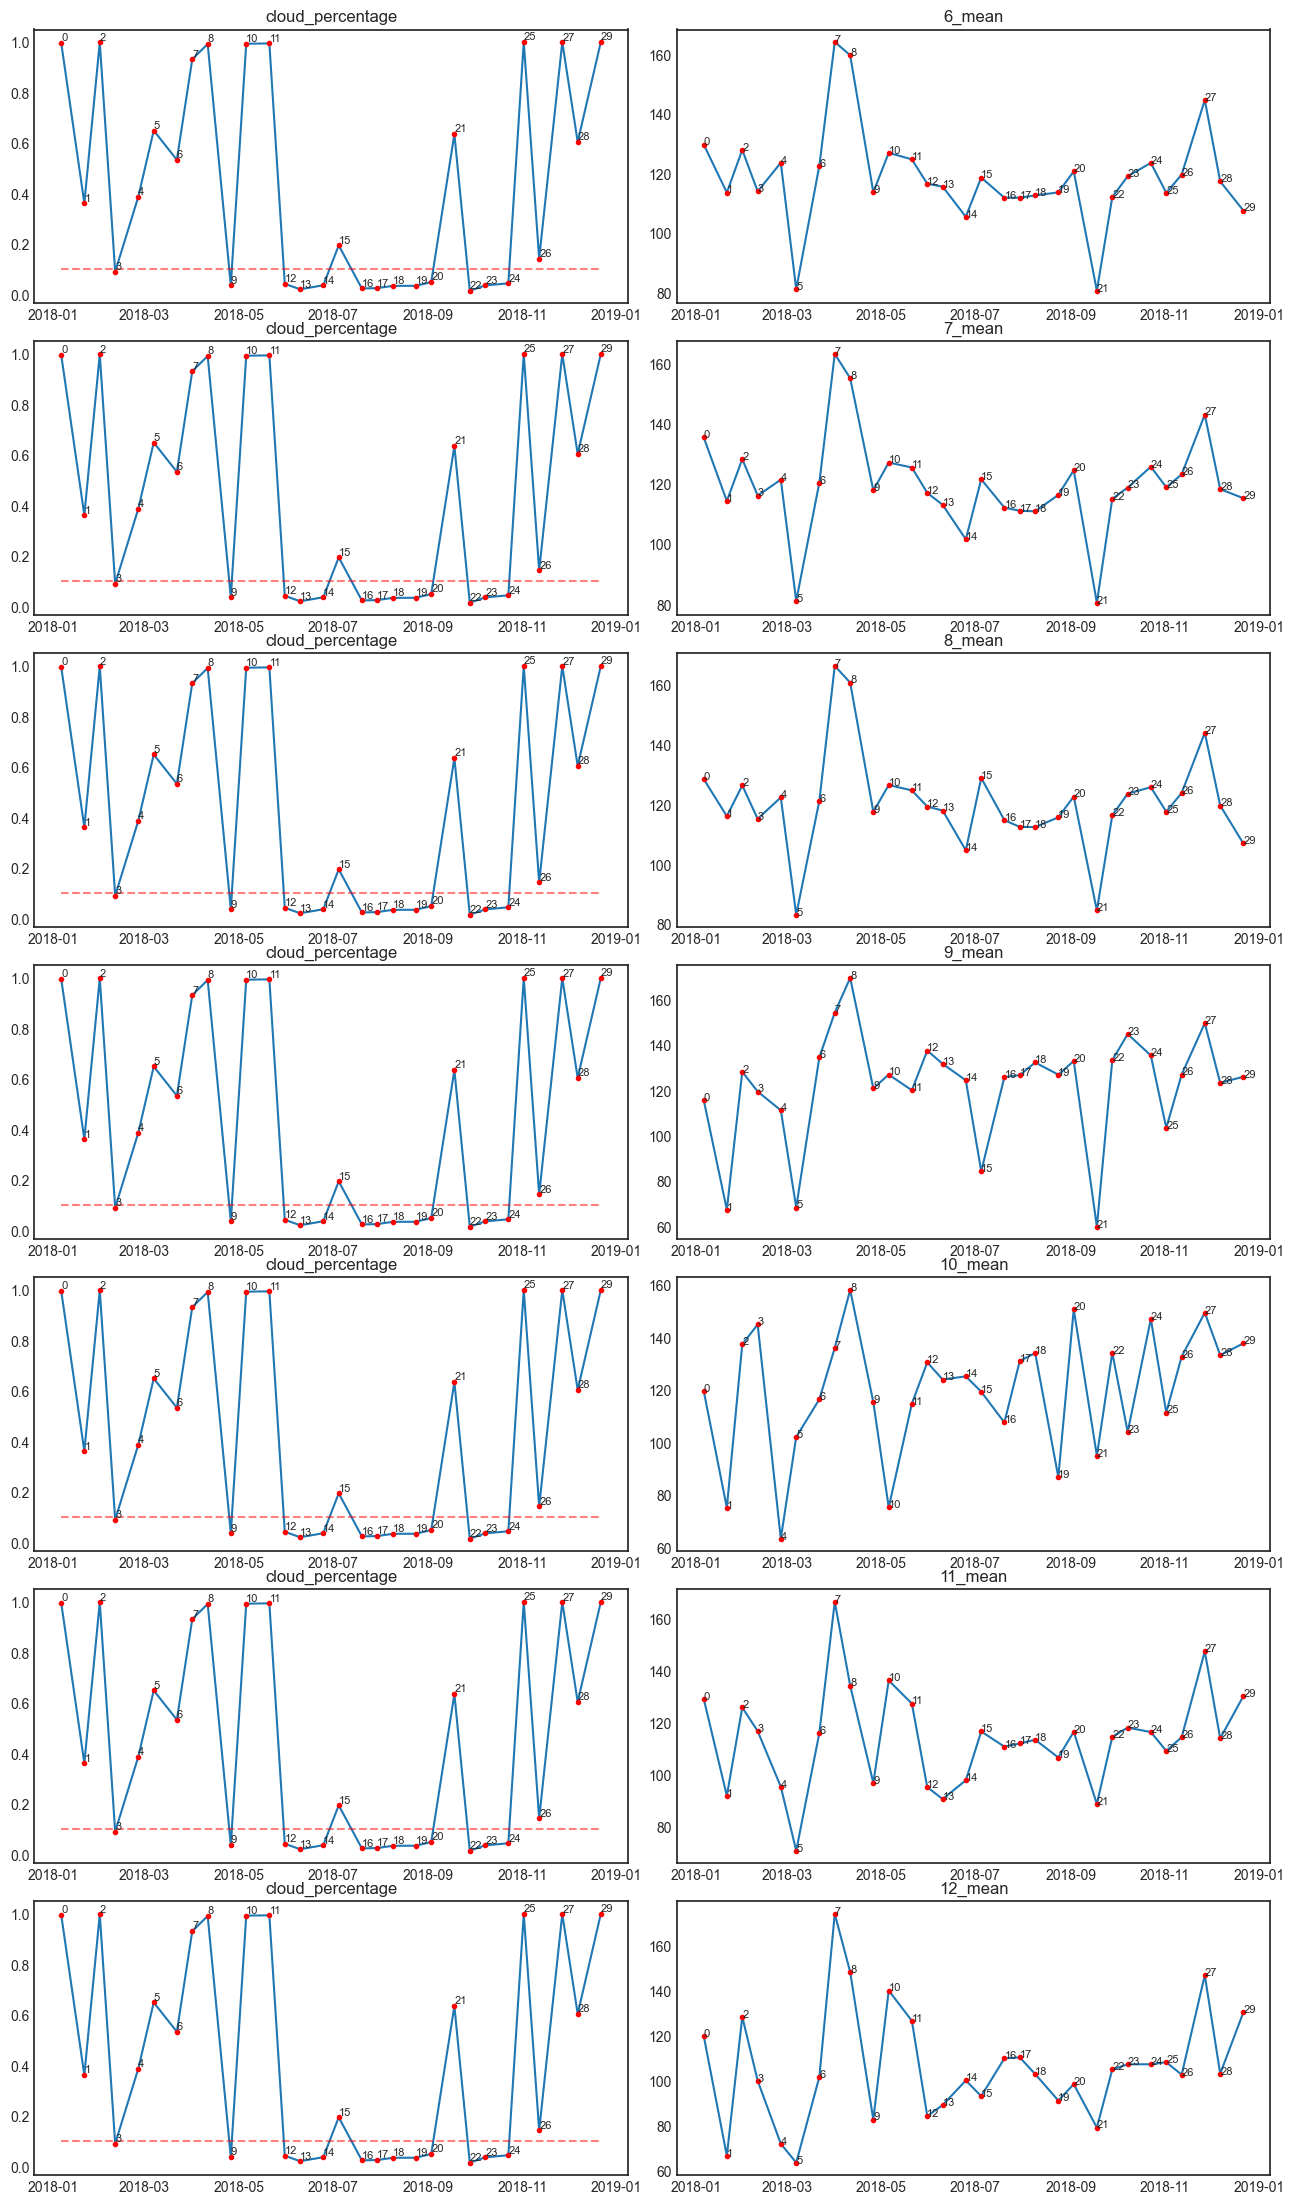

In [26]:
BAND_FEATS = [f"{i}_mean" for i in range(13)]
fig, axs = plt.subplots(13 // 2 + 1, 2, figsize=(13, 3*13 // 2 + 3))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(BAND_FEATS[6:], axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)
fig.savefig(r'C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\eda\merge\cloud-percentage-each-time-interval-band-2.png')

### Show indexs

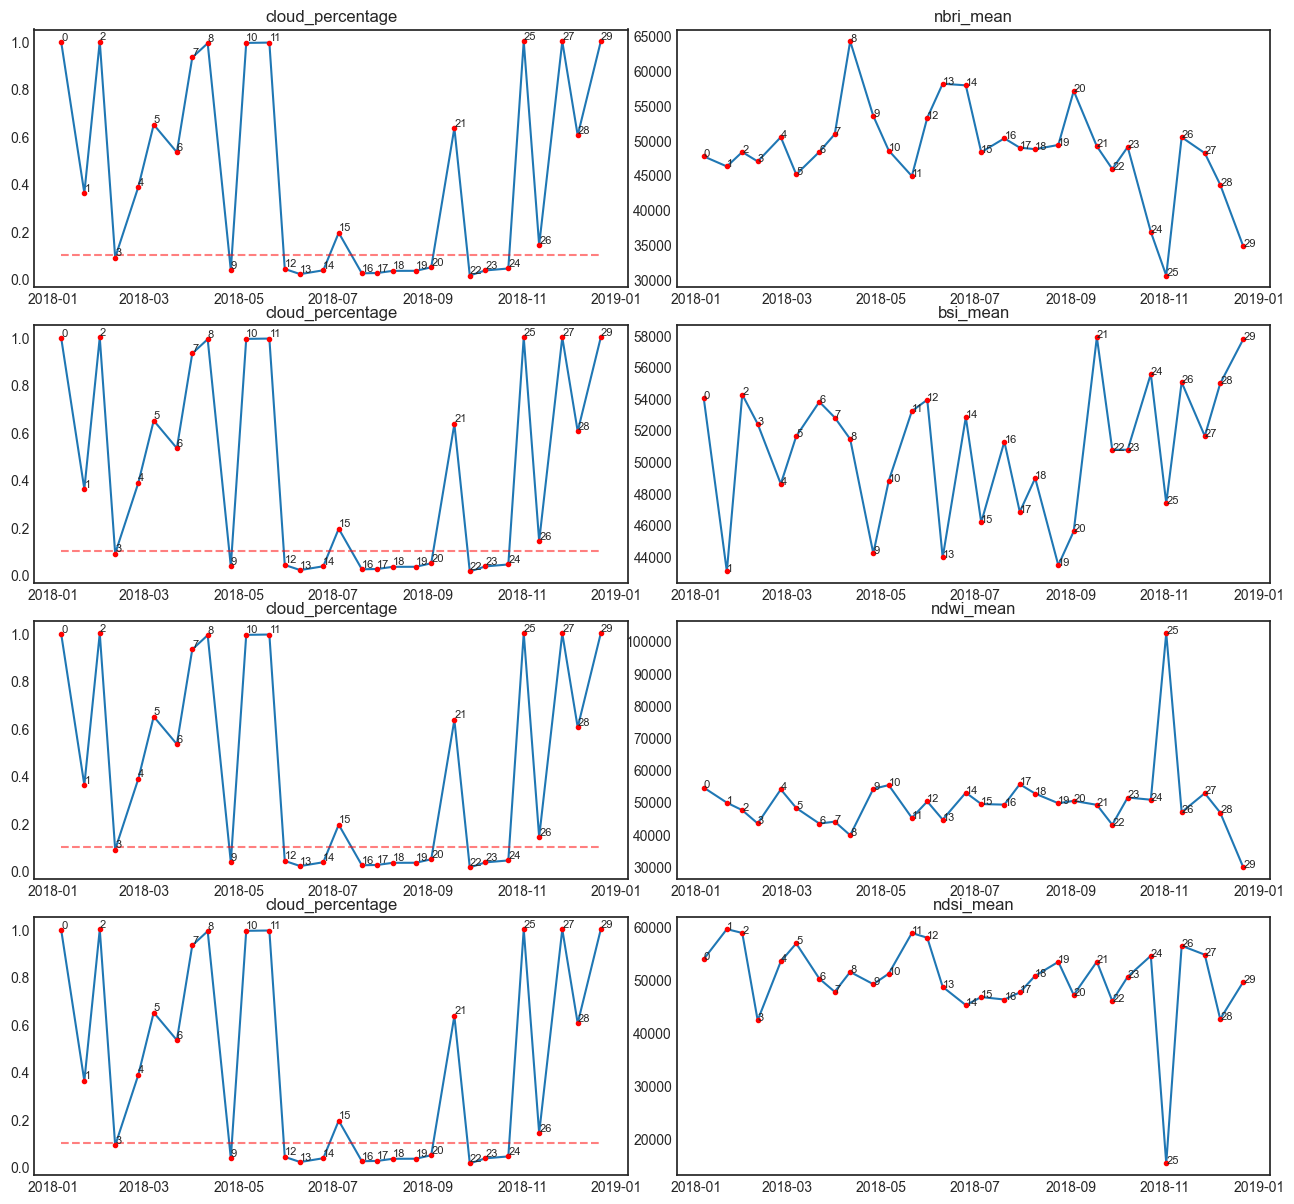

In [22]:
INDEXS = ["ndvi", "gndvi", "ndmi", "msi", "nbri", "bsi", "ndwi", "ndsi"]
INDEX_FEATS = [f"{index}_mean" for index in INDEXS]
fig, axs = plt.subplots(len(INDEXS), 2, figsize=(13, 3*len(INDEXS)))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(INDEX_FEATS, axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)
fig.savefig(r'C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\eda\merge\cloud-percentage-each-time-interval-index.png')

### Outlier detection

- IQR
- Standard deviation
- Z-score

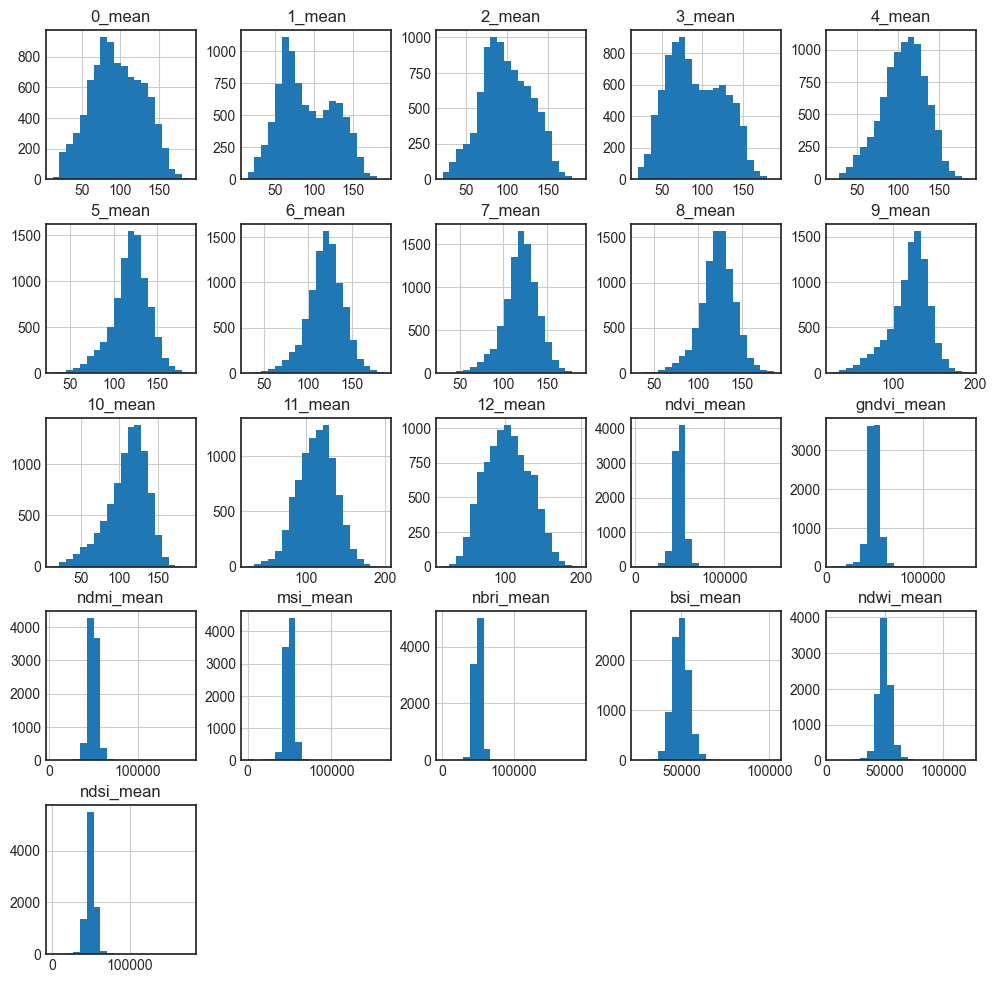

In [15]:
OUTLIER_FEATS = BAND_FEATS + INDEX_FEATS
df[OUTLIER_FEATS].hist(bins=20, figsize=(12, 12))
pass

In [16]:
def show_outlier_properties(outliers, feats=('patch', 'time_interval')):
    """
    This function will show the outlier df distribution
    """
    fig, axs = plt.subplots(len(feats),1, figsize=(16, 3))
    fig.tight_layout(h_pad=2)
    for feat_plot, row_ax in zip(feats, axs):
        value_counts = outliers[feat_plot].value_counts()
        if feat_plot == 'time_interval':
            value_counts = value_counts.sort_index()
        value_counts.plot(kind='bar', ax=row_ax)
        row_ax.set_title(feat_plot)

#### IQR

33 outliers


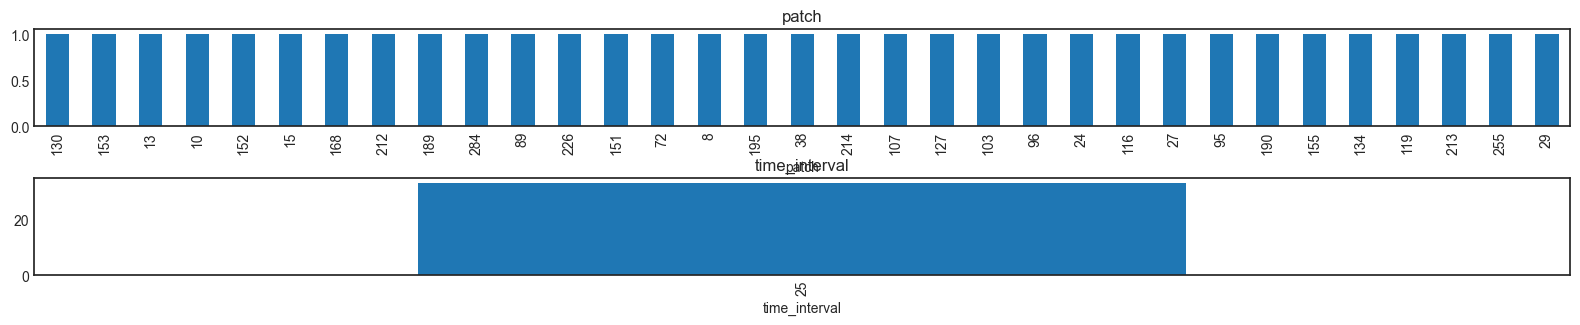

In [17]:
def iqr_outlier_detection(df):
    q1 = df[INDEX_FEATS].quantile(0.25)
    q3 = df[INDEX_FEATS].quantile(0.75)
    iqr = q3 - q1
    outliers = (df[((df[INDEX_FEATS] < (q1 - 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (q3 + 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
iqr_outliers = iqr_outlier_detection(df)
print(iqr_outliers.shape[0], "outliers")
show_outlier_properties(iqr_outliers)

In [18]:
iqr_outlier_detection(patch_df)

Empty DataFrame
Columns: [0_traditional_contrast, 0_michelson_contrast, 0_rms_contrast, 0_laplacian_blur, 0_mean, 0_median, 0_p25, 0_p75, 0_std, 1_traditional_contrast, 1_michelson_contrast, 1_rms_contrast, 1_laplacian_blur, 1_mean, 1_median, 1_p25, 1_p75, 1_std, 2_traditional_contrast, 2_michelson_contrast, 2_rms_contrast, 2_laplacian_blur, 2_mean, 2_median, 2_p25, 2_p75, 2_std, 3_traditional_contrast, 3_michelson_contrast, 3_rms_contrast, 3_laplacian_blur, 3_mean, 3_median, 3_p25, 3_p75, 3_std, 4_traditional_contrast, 4_michelson_contrast, 4_rms_contrast, 4_laplacian_blur, 4_mean, 4_median, 4_p25, 4_p75, 4_std, 5_traditional_contrast, 5_michelson_contrast, 5_rms_contrast, 5_laplacian_blur, 5_mean, 5_median, 5_p25, 5_p75, 5_std, 6_traditional_contrast, 6_michelson_contrast, 6_rms_contrast, 6_laplacian_blur, 6_mean, 6_median, 6_p25, 6_p75, 6_std, 7_traditional_contrast, 7_michelson_contrast, 7_rms_contrast, 7_laplacian_blur, 7_mean, 7_median, 7_p25, 7_p75, 7_std, 8_traditional_contrast, 8_michelson_contrast, 8_rms_contrast, 8_laplacian_blur, 8_mean, 8_median, 8_p25, 8_p75, 8_std, 9_traditional_contrast, 9_michelson_contrast, 9_rms_contrast, 9_laplacian_blur, 9_mean, 9_median, 9_p25, 9_p75, 9_std, 10_traditional_contrast, 10_michelson_contrast, 10_rms_contrast, 10_laplacian_blur, 10_mean, 10_median, 10_p25, 10_p75, 10_std, 11_traditional_contrast, ...]
Index: []

[0 rows x 211 columns]

#### STD Deviation

In [19]:
def std_deviation_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    outliers = (df[((df[INDEX_FEATS] < (mean - 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (mean + 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
std_deviation_outlier_detection(patch_df)

Empty DataFrame
Columns: [0_traditional_contrast, 0_michelson_contrast, 0_rms_contrast, 0_laplacian_blur, 0_mean, 0_median, 0_p25, 0_p75, 0_std, 1_traditional_contrast, 1_michelson_contrast, 1_rms_contrast, 1_laplacian_blur, 1_mean, 1_median, 1_p25, 1_p75, 1_std, 2_traditional_contrast, 2_michelson_contrast, 2_rms_contrast, 2_laplacian_blur, 2_mean, 2_median, 2_p25, 2_p75, 2_std, 3_traditional_contrast, 3_michelson_contrast, 3_rms_contrast, 3_laplacian_blur, 3_mean, 3_median, 3_p25, 3_p75, 3_std, 4_traditional_contrast, 4_michelson_contrast, 4_rms_contrast, 4_laplacian_blur, 4_mean, 4_median, 4_p25, 4_p75, 4_std, 5_traditional_contrast, 5_michelson_contrast, 5_rms_contrast, 5_laplacian_blur, 5_mean, 5_median, 5_p25, 5_p75, 5_std, 6_traditional_contrast, 6_michelson_contrast, 6_rms_contrast, 6_laplacian_blur, 6_mean, 6_median, 6_p25, 6_p75, 6_std, 7_traditional_contrast, 7_michelson_contrast, 7_rms_contrast, 7_laplacian_blur, 7_mean, 7_median, 7_p25, 7_p75, 7_std, 8_traditional_contrast, 8_michelson_contrast, 8_rms_contrast, 8_laplacian_blur, 8_mean, 8_median, 8_p25, 8_p75, 8_std, 9_traditional_contrast, 9_michelson_contrast, 9_rms_contrast, 9_laplacian_blur, 9_mean, 9_median, 9_p25, 9_p75, 9_std, 10_traditional_contrast, 10_michelson_contrast, 10_rms_contrast, 10_laplacian_blur, 10_mean, 10_median, 10_p25, 10_p75, 10_std, 11_traditional_contrast, ...]
Index: []

[0 rows x 211 columns]

#### Z-score 

33 outliers


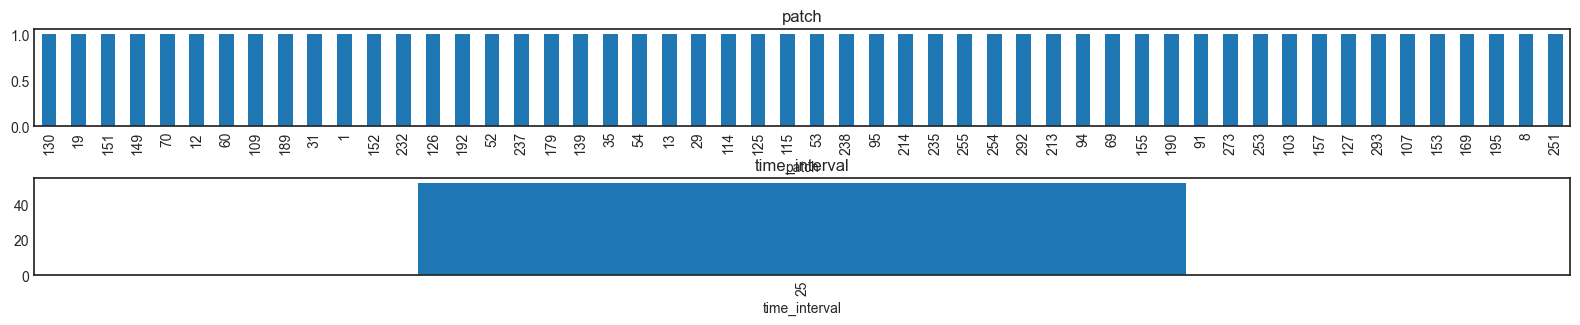

In [20]:
def z_score_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    z_score = ((df[INDEX_FEATS] - mean) / std).abs()
    outliers = df[((z_score > 3).sum(axis=1) > len(INDEX_FEATS) // 2)]
    return outliers

z_score_outliers = z_score_outlier_detection(df)
print(iqr_outliers.shape[0], "outliers")
show_outlier_properties(z_score_outliers)

In [21]:
# How would be with any outlier from any feat?
df[(((df[INDEX_FEATS] - df[INDEX_FEATS].mean()) / df[INDEX_FEATS].std()).abs() > 3).any(axis=1) & (df.patch == PATCH)]

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
7621                0.593602                   1.0       64.269825   
8806                0.614906                   1.0       67.702058   

      0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
7621        330.228814  108.270981      95.0   62.0  151.0  64.269825   
8806        132.980431  110.101486     104.0   57.0  155.0  67.702058   

      1_traditional_contrast  ...  ndsi_under25  ndsi_p75  ndsi_over75  \
7621                0.518793  ...       16376.0  0.902524      16384.0   
8806                0.548511  ...       16383.0  2.381818      16378.0   

           roi  season  patch  scene  time_interval       time  continent  
7621  ROIs2017  autumn      0    146             25 2018-11-02     europa  
8806  ROIs2017  winter      0    146             29 2018-12-22     europa  

[2 rows x 211 columns]

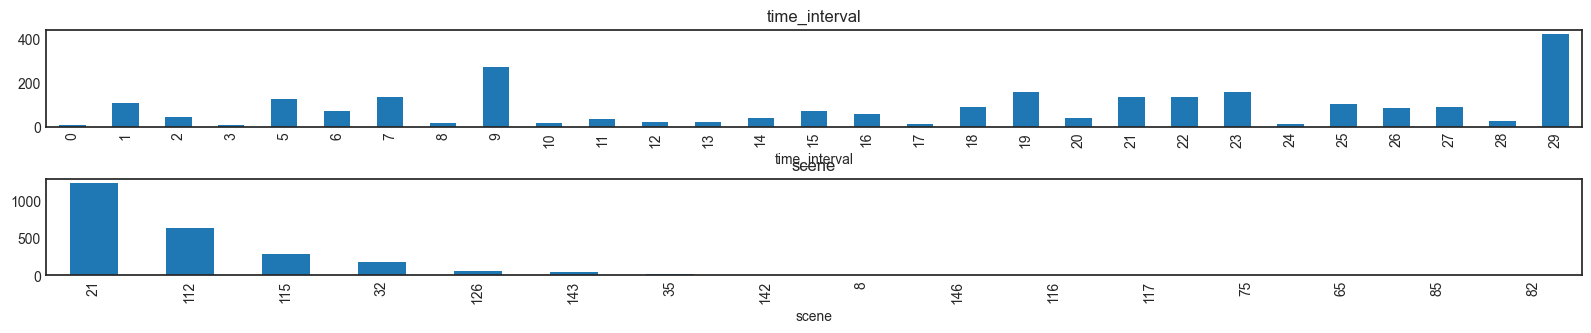

In [22]:
z_score_outliers = z_score_outlier_detection(all_df)
show_outlier_properties(z_score_outliers, ('time_interval', 'scene'))

In [23]:
all_df['is_outlier'] = False
all_df.loc[z_score_outliers.index, 'is_outlier'] = True

## Classification
### How to detect cloudy images without %?

In [24]:
LIMIT = 0.1
df['is_cloudy'] = df['cloud_percentage'] > LIMIT
all_df['is_cloudy'] = all_df['cloud_percentage'] > LIMIT
patch_df['is_cloudy'] = patch_df['cloud_percentage'] > LIMIT

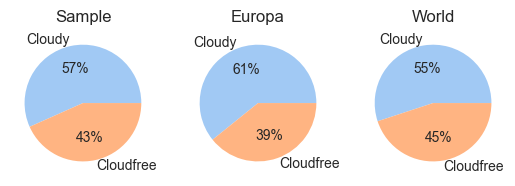

In [25]:
fig, axs = plt.subplots(1, 3)
for ax, df_, title in zip(axs, [patch_df, df, all_df], ["Sample", "Europa", "World"]):
    colors = sns.color_palette('pastel')[0:5]
    ax.pie(df_['is_cloudy'].value_counts(), labels=['Cloudy', 'Cloudfree'], colors=colors, autopct='%.0f%%')
    ax.set_title(title)
fig.savefig("imgs/doc/population.png")

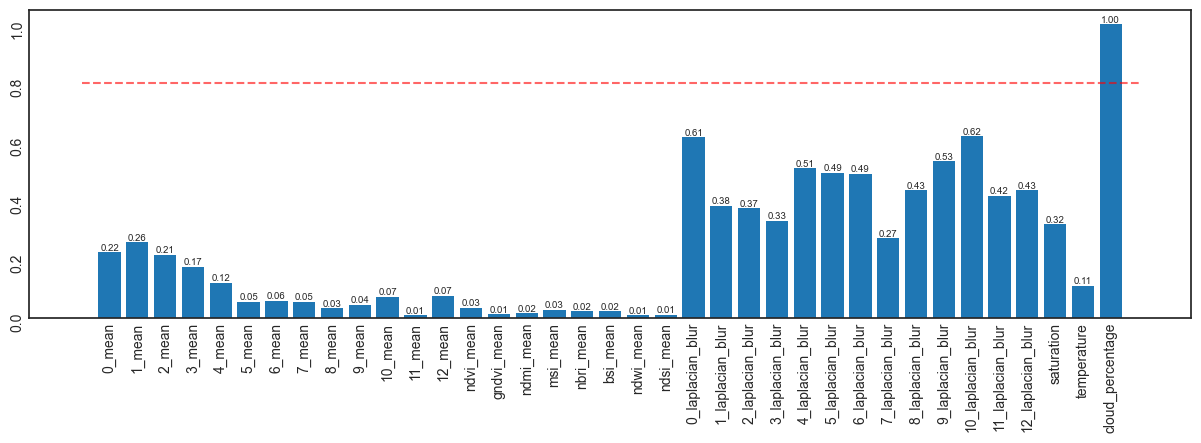

In [26]:
CORR_FEATS = OUTLIER_FEATS + [f"{i}_laplacian_blur" for i in range(13)] + ['saturation', 'temperature', 'cloud_percentage']
def show_corr_from(df, feat, ax=None, show_perc=False):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(15, 4))
    corrs = df[CORR_FEATS].corr()[feat].abs()
    p = ax.bar(corrs.index, corrs.values)
    ax.tick_params(rotation=90)
    #p = corrs.plot(kind='bar', ax=ax)
    if show_perc:
        ax.bar_label(p, label_type='edge', fmt="{:.2f}", fontsize="x-small")
    ax.plot([-1, len(CORR_FEATS)], [0.8, 0.8], '--r', alpha=0.6)
    return corrs
corrs_all_df = show_corr_from(all_df, 'cloud_percentage', show_perc=True)

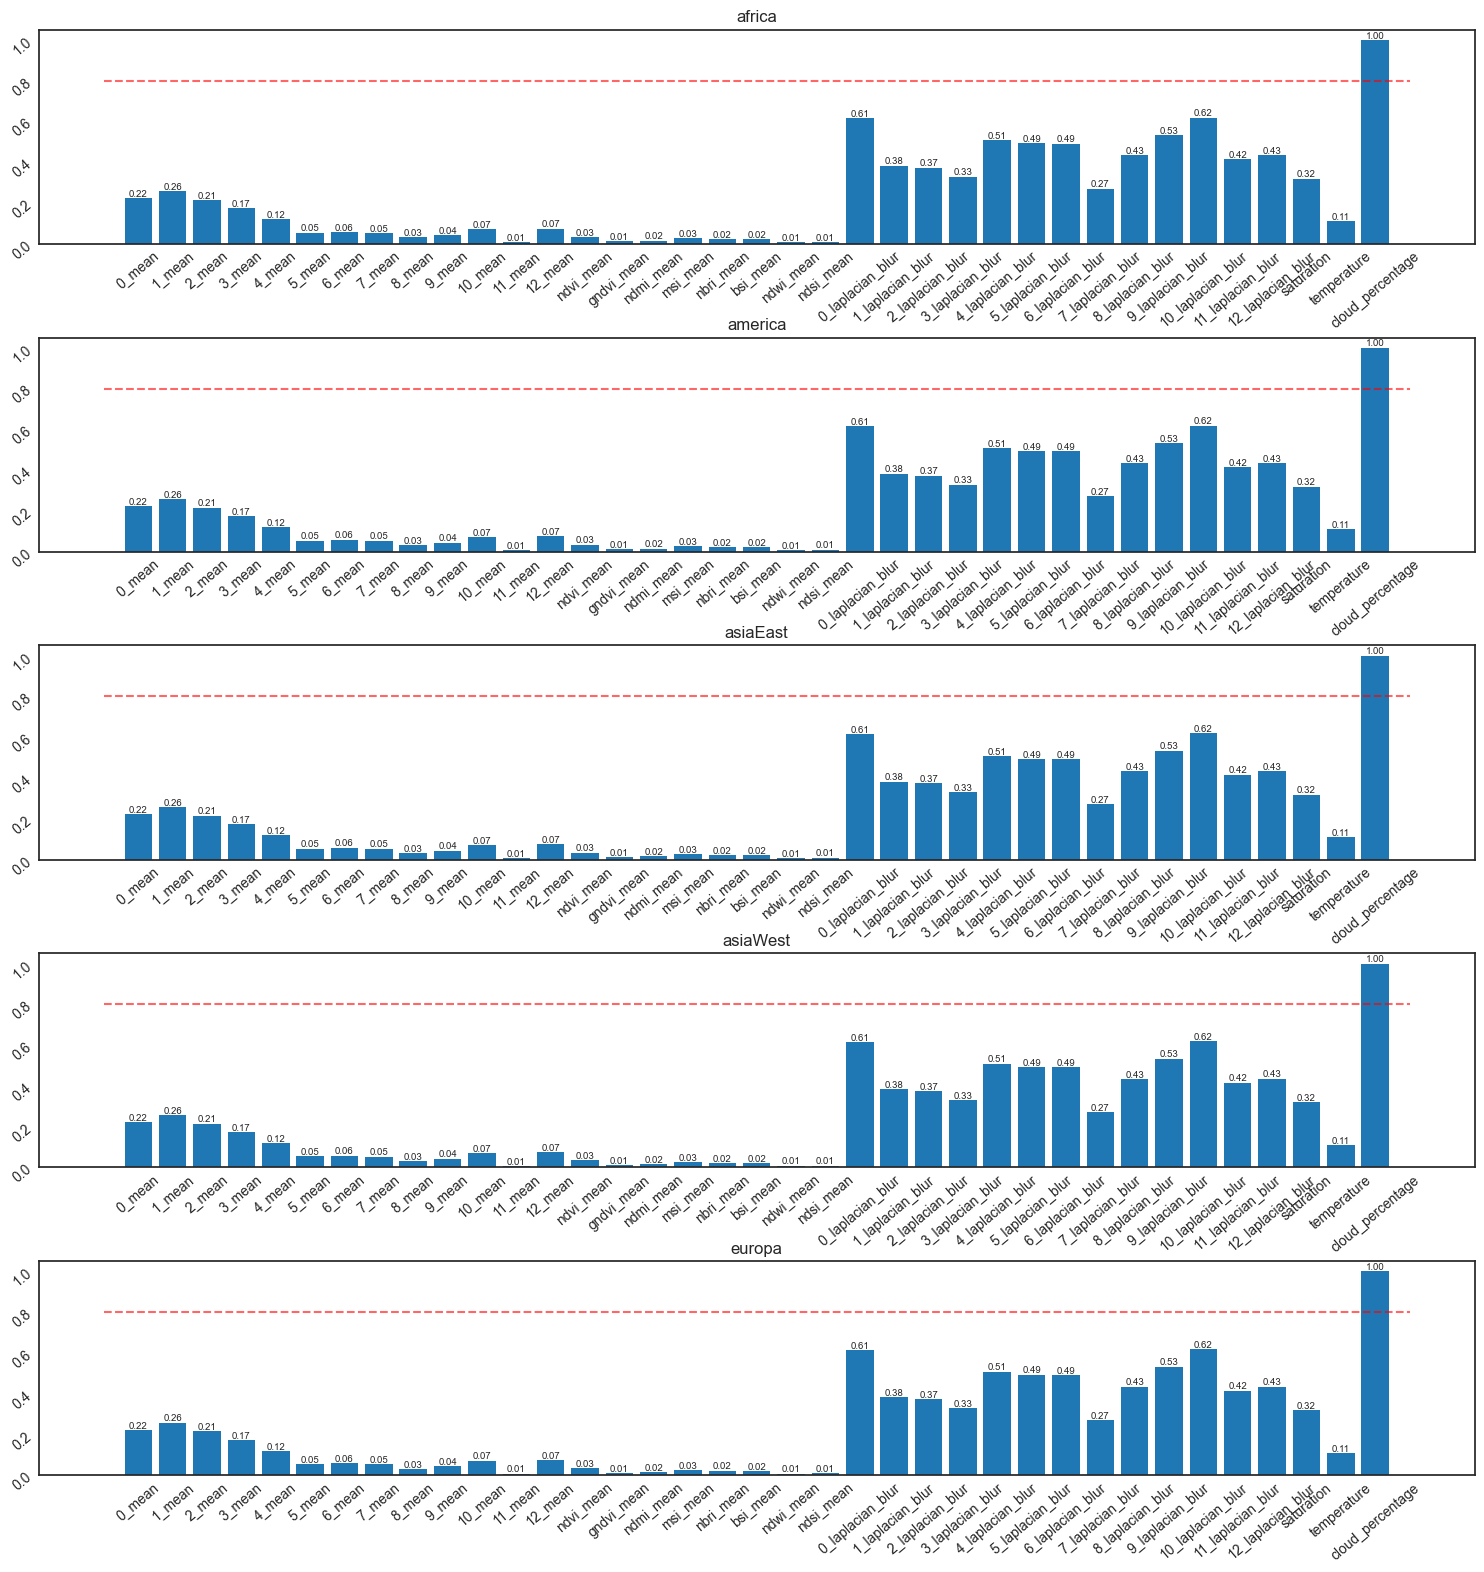

In [27]:
continents = all_df['continent'].unique()
fig, axs = plt.subplots(len(continents), 1, figsize=(15, len(continents) * 3))
fig.tight_layout(h_pad=5)
for ax, continent in zip(axs, continents):
    show_corr_from(all_df, 'cloud_percentage', ax=ax, show_perc=True)
    ax.set_title(continent)
    ax.tick_params(rotation=40)

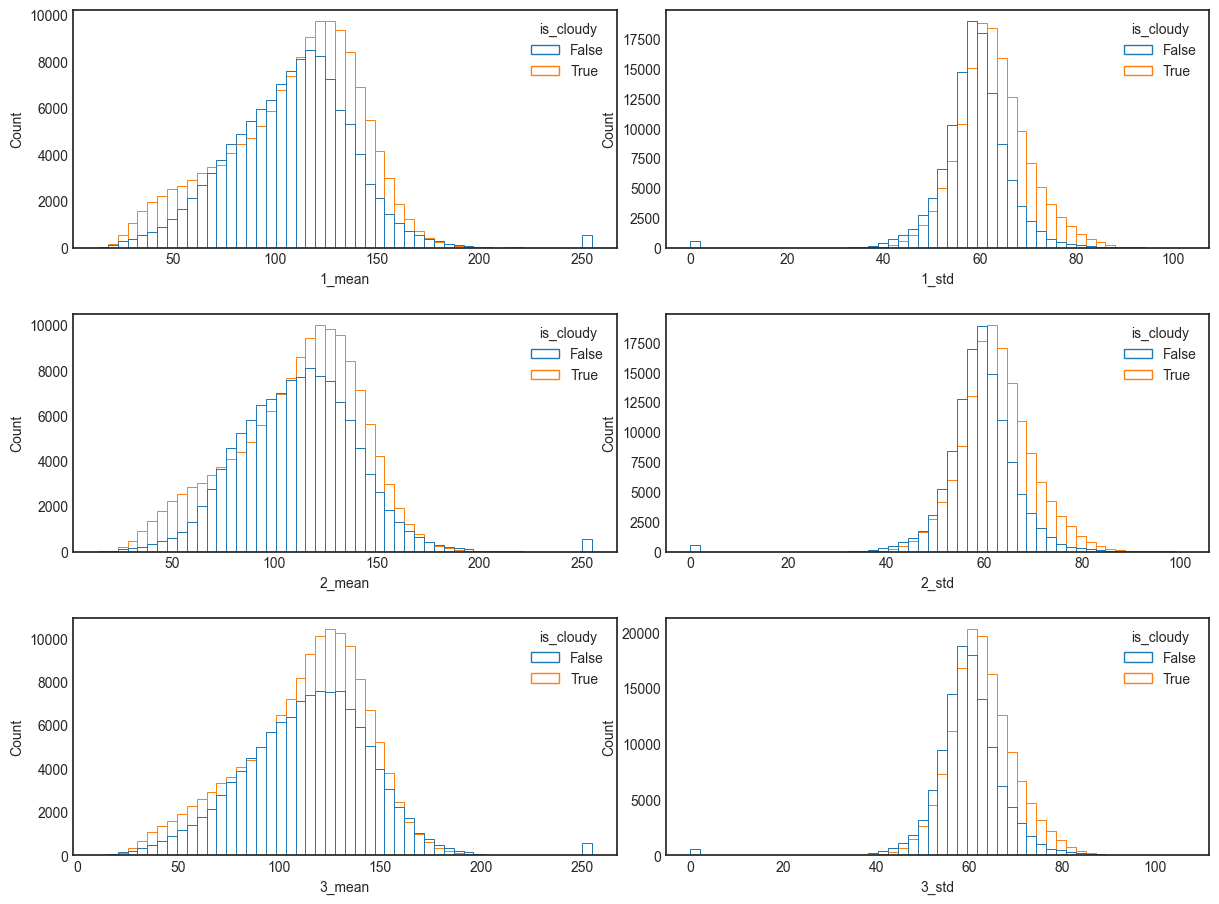

In [28]:
VISIBLE_BANDS = [[f"{i}_{value}" for value in ["mean", "std"]] for i in [1,2,3]]
fig, axs = plt.subplots(len(VISIBLE_BANDS), 2, figsize=(12, 3 * len(VISIBLE_BANDS)))
fig.tight_layout(h_pad=3)
for (i, (mean_value, std_value), (mean_ax, std_ax)) in enumerate(zip(VISIBLE_BANDS, axs)):
    mean_ax.set_title("B{} mean histogram".format(i+1))
    std_ax.set_title("B{} std histogram".format(i+1))
    sns.histplot(data=all_df, x=mean_value, hue='is_cloudy', bins=50, ax=mean_ax, fill=False)
    sns.histplot(data=all_df, x=std_value, hue='is_cloudy', bins=50, ax=std_ax, fill=False)
fig.savefig('imgs/doc/mean-std-cloudy-histogram.png')

### Pair bindings

In [29]:
df

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
0                   0.454809                   1.0       61.043858   
1                   0.529204                   1.0       59.268642   
2                   0.662275                   1.0       75.088112   
3                   0.545177                   1.0       67.938653   
4                   0.558616                   1.0       68.171819   
...                      ...                   ...             ...   
8995                0.438691                   1.0       60.909182   
8996                0.560149                   1.0       72.217894   
8997                0.518879                   1.0       62.181598   
8998                0.562221                   1.0       64.592046   
8999                0.514942                   1.0       66.155614   

      0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
0           253.599681  134.218811     132.0   91.0  180.0  61.043858   
1           234.429785  111.995728     114.0   71.0  147.0  59.268642   
2           151.575154  113.379059     119.0   45.0  176.0  75.088112   
3           274.614714  124.617508     127.0   72.0  175.0  67.938653   
4           170.130609  122.037018     124.0   67.0  174.0  68.171819   
...                ...         ...       ...    ...    ...        ...   
8995         84.376351  138.843063     136.0   98.0  189.0  60.909182   
8996         98.861022  128.926178     133.0   67.0  183.0  72.217894   
8997        257.301247  119.838318     114.0   76.0  160.0  62.181598   
8998        105.532928  114.887238     115.0   62.0  164.0  64.592046   
8999         59.107569  128.471970     128.0   80.0  179.0  66.155614   

      1_traditional_contrast  ...  ndsi_p75  ndsi_over75       roi  season  \
0                   0.474263  ...  2.031579      16382.0  ROIs2017  winter   
1                   0.495702  ...  2.000000      16382.0  ROIs2017  winter   
2                   0.716577  ...  2.035088      16382.0  ROIs2017  winter   
3                   0.535494  ...  1.999999      16381.0  ROIs2017  winter   
4                   0.555745  ...  1.976744      16381.0  ROIs2017  winter   
...                      ...  ...       ...          ...       ...     ...   
8995                0.447293  ...  1.913043      16383.0  ROIs2017  winter   
8996                0.533237  ...  1.895642      16384.0  ROIs2017  winter   
8997                0.495049  ...  2.319149      16382.0  ROIs2017  winter   
8998                0.579240  ...  1.983871      16383.0  ROIs2017  winter   
8999                0.513552  ...  2.019607      16384.0  ROIs2017  winter   

      patch  scene  time_interval       time  continent  is_cloudy  
0       191    146              0 2018-01-06     europa       True  
1       146    146              0 2018-01-06     europa       True  
2       261    146              0 2018-01-06     europa       True  
3       163    146              0 2018-01-06     europa       True  
4       269    146              0 2018-01-06     europa       True  
...     ...    ...            ...        ...        ...        ...  
8995    156    146             29 2018-12-22     europa       True  
8996    162    146             29 2018-12-22     europa       True  
8997     70    146             29 2018-12-22     europa       True  
8998    282    146             29 2018-12-22     europa       True  
8999    295    146             29 2018-12-22     europa       True  

[9000 rows x 212 columns]

In [30]:
from collections import defaultdict

def get_pairings(all_df_, max_pairings_per_patch=1):
    new_df = defaultdict(list)
    for (roi, season, patch, scene, continent), group in all_df_.groupby(by=['roi', 'season', 'patch', 'scene', 'continent']):
        cloud_perc_group = group['is_cloudy'].sum() / group.shape[0]
        cloudy_indices = np.where(group['is_cloudy'])[0]
        cloudless_indices = np.where(~group['is_cloudy'])[0]
        pairings = list(zip(cloudy_indices, cloudless_indices))[:max_pairings_per_patch]
        for p_cloudy, p_cloudless in pairings:
            new_df['roi'].append(roi)
            new_df['season'].append(season)
            new_df['patch'].append(patch)
            new_df['scene'].append(scene)
            new_df['continent'].append(continent)
            new_df['cloudy_interval'].append(p_cloudy)
            new_df['cloudless_interval'].append(p_cloudless)
    new_df = pd.DataFrame(new_df)
    return new_df
new_df = get_pairings(all_df)

In [31]:
INPUT_FOLDER = "/data/docker/volumes/laclasse/SEN12MS-CR"

def get_path(df_, type_int, s_type):
    return df_.apply(lambda x: "/{c}/{r}/{s}/{st}/{ti}/".format(c=x['continent'], r=x['roi'], s=x['scene'], st=s_type, ti=x[type_int]), axis=1)


new_df['path_cloudy'] = get_path(new_df, 'cloudy_interval', 'S2')
new_df['path_cloudless'] = get_path(new_df, 'cloudless_interval', 'S2')
new_df['path_s1'] = get_path(new_df, 'cloudy_interval', 'S1')

new_df['path_cloudy'][0], new_df['path_cloudless'][0], new_df['path_s1'][0]

('/america/ROIs1158/106/S2/0/',
 '/america/ROIs1158/106/S2/1/',
 '/america/ROIs1158/106/S1/0/')

In [32]:
import re

def find_img_patch(row, list, type, interval_type):
    for el in list:
        if re.match("^{type}_{roi}_{scene}_ImgNo_{int}_\d\d\d\d-\d\d-\d\d_patch_{patch}\.tif".format(type=type, roi=row['roi'], scene=row['scene'], int=row[interval_type], patch=row['patch']), el):
            return el
    raise Exception("File not found type={type} roi={roi} scene={scene} interval={i} patch={p}".format(type=type, roi=row['roi'], scene=row['scene'], i=row[interval_type], p=patch))

find_img_patch(new_df.iloc[0],
        ["s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_1.tif", "s1_ROIs1158_106_ImgNo_1_2018-01-16_patch_0.tif", "s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_0.tif"],
        "s2",
        "cloudy_interval")

's2_ROIs1158_106_ImgNo_0_2018-01-04_patch_0.tif'

In [33]:
new_df

roi  season  patch  scene continent  cloudy_interval  \
0      ROIs1158  autumn      0    106   america                0   
1      ROIs1158  autumn      1    106   america                0   
2      ROIs1158  autumn      2    106   america                0   
3      ROIs1158  autumn      3    106   america                0   
4      ROIs1158  autumn      4    106   america                0   
...         ...     ...    ...    ...       ...              ...   
30092  ROIs2017  winter    287     25  asiaEast                5   
30093  ROIs2017  winter    287    146    europa                0   
30094  ROIs2017  winter    288    146    europa                0   
30095  ROIs2017  winter    289    146    europa                0   
30096  ROIs2017  winter    295    146    europa                0   

       cloudless_interval                  path_cloudy  \
0                       1  /america/ROIs1158/106/S2/0/   
1                       1  /america/ROIs1158/106/S2/0/   
2                       1  /america/ROIs1158/106/S2/0/   
3                       1  /america/ROIs1158/106/S2/0/   
4                       1  /america/ROIs1158/106/S2/0/   
...                   ...                          ...   
30092                   0  /asiaEast/ROIs2017/25/S2/5/   
30093                   4   /europa/ROIs2017/146/S2/0/   
30094                   4   /europa/ROIs2017/146/S2/0/   
30095                   4   /europa/ROIs2017/146/S2/0/   
30096                   4   /europa/ROIs2017/146/S2/0/   

                    path_cloudless                      path_s1  
0      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/  
1      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/  
2      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/  
3      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/  
4      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/  
...                            ...                          ...  
30092  /asiaEast/ROIs2017/25/S2/0/  /asiaEast/ROIs2017/25/S1/5/  
30093   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/  
30094   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/  
30095   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/  
30096   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/  

[30097 rows x 10 columns]

In [34]:
new_df.to_pickle("data/input/ts_pairings_incomplete.pkl")

In [36]:
finished_df = pd.read_pickle("data/input/ts_pairings_1.pkl")
finished_df

roi  season  patch  scene continent  cloudy_interval  \
0      ROIs1158  autumn      0    106   america                0   
1      ROIs1158  autumn      1    106   america                0   
2      ROIs1158  autumn      2    106   america                0   
3      ROIs1158  autumn      3    106   america                0   
4      ROIs1158  autumn      4    106   america                0   
...         ...     ...    ...    ...       ...              ...   
30092  ROIs2017  winter    287     25  asiaEast                5   
30093  ROIs2017  winter    287    146    europa                0   
30094  ROIs2017  winter    288    146    europa                0   
30095  ROIs2017  winter    289    146    europa                0   
30096  ROIs2017  winter    295    146    europa                0   

       cloudless_interval                  path_cloudy  \
0                       1  /america/ROIs1158/106/S2/0/   
1                       1  /america/ROIs1158/106/S2/0/   
2                       1  /america/ROIs1158/106/S2/0/   
3                       1  /america/ROIs1158/106/S2/0/   
4                       1  /america/ROIs1158/106/S2/0/   
...                   ...                          ...   
30092                   0  /asiaEast/ROIs2017/25/S2/5/   
30093                   4   /europa/ROIs2017/146/S2/0/   
30094                   4   /europa/ROIs2017/146/S2/0/   
30095                   4   /europa/ROIs2017/146/S2/0/   
30096                   4   /europa/ROIs2017/146/S2/0/   

                    path_cloudless                      path_s1  \
0      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/   
1      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/   
2      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/   
3      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/   
4      /america/ROIs1158/106/S2/1/  /america/ROIs1158/106/S1/0/   
...                            ...                          ...   
30092  /asiaEast/ROIs2017/25/S2/0/  /asiaEast/ROIs2017/25/S1/5/   
30093   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/   
30094   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/   
30095   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/   
30096   /europa/ROIs2017/146/S2/4/   /europa/ROIs2017/146/S1/0/   

                                        cloudy_img_path  \
0        s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_0.tif   
1        s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_1.tif   
2        s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_2.tif   
3        s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_3.tif   
4        s2_ROIs1158_106_ImgNo_0_2018-01-04_patch_4.tif   
...                                                 ...   
30092   s2_ROIs2017_25_ImgNo_5_2018-03-03_patch_287.tif   
30093  s2_ROIs2017_146_ImgNo_0_2018-01-06_patch_287.tif   
30094  s2_ROIs2017_146_ImgNo_0_2018-01-06_patch_288.tif   
30095  s2_ROIs2017_146_ImgNo_0_2018-01-06_patch_289.tif   
30096  s2_ROIs2017_146_ImgNo_0_2018-01-06_patch_295.tif   

                                           sar_img_path  \
0        s1_ROIs1158_106_ImgNo_0_2018-01-04_patch_0.tif   
1        s1_ROIs1158_106_ImgNo_0_2018-01-04_patch_1.tif   
2        s1_ROIs1158_106_ImgNo_0_2018-01-04_patch_2.tif   
3        s1_ROIs1158_106_ImgNo_0_2018-01-04_patch_3.tif   
4        s1_ROIs1158_106_ImgNo_0_2018-01-04_patch_4.tif   
...                                                 ...   
30092   s1_ROIs2017_25_ImgNo_5_2018-03-04_patch_287.tif   
30093  s1_ROIs2017_146_ImgNo_0_2018-01-07_patch_287.tif   
30094  s1_ROIs2017_146_ImgNo_0_2018-01-07_patch_288.tif   
30095  s1_ROIs2017_146_ImgNo_0_2018-01-07_patch_289.tif   
30096  s1_ROIs2017_146_ImgNo_0_2018-01-07_patch_295.tif   

                                     cloudless_img_path  
0        s2_ROIs1158_106_ImgNo_1_2018-01-16_patch_0.tif  
1        s2_ROIs1158_106_ImgNo_1_2018-01-16_patch_1.tif  
2        s2_ROIs1158_106_ImgNo_1_2018-01-16_patch_2.tif  
3        s2_ROIs1158_106_ImgNo_1_2018-01-16

In [40]:
finished_df.set_index(['scene', 'season', 'roi', 'patch'])[["cloudy_img_path", "sar_img_path", "cloudless_img_path", "continent"]].to_pickle("data/input/ts_pairings_1.pkl")